# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:

#Make allNecessary Imports
import os
import zipfile
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

# For inline plotting in notebooks
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


# Data Loading and Extraction

In [26]:

def extract_zip(zip_path: str, extract_to: str):
    """
    Extracts a zip file to the specified directory.
    """
    os.makedirs(extract_to, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted files to {extract_to}")

# Path to the zipped audio dataset
unlabelled_data_path = "/content/drive/MyDrive/Data/unlabelled_sounds.zip"
temp_audio_dir = "/content/temp_audio"

# Extract the audio files
extract_zip(unlabelled_data_path, temp_audio_dir)

def load_audio_file_paths(root_dir: str, extensions=('.wav', '.mp3', '.ogg')):
    """
    Recursively collects paths to audio files with the given extensions.
    """
    audio_files = []
    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(extensions):
                audio_files.append(os.path.join(root, file))
    print(f"Found {len(audio_files)} audio files in {root_dir}")
    return audio_files

audio_files = load_audio_file_paths(temp_audio_dir)


Extracted files to /content/temp_audio
Found 3000 audio files in /content/temp_audio


#Feature Extraction

In [27]:

def extract_audio_features(file_path: str):
    """
    Extract audio features from a file using librosa.

    Extracts:
    - MFCC (13 coefficients)
    - Spectral centroid, bandwidth, rolloff, and zero crossing rate (each averaged over time)
    - Mel Spectrogram (mean and standard deviation of log-power values)

    Returns a 1D numpy array of features.
    """
    try:
        y, sr = librosa.load(file_path, sr=None)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

    # MFCCs
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)

    # Mel Spectrogram (log-scaled) and summary statistics
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec)
    mel_mean = np.mean(mel_spec_db)
    mel_std = np.std(mel_spec_db)

    # Other spectral features
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr).T, axis=0)
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr).T, axis=0)
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr).T, axis=0)
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y).T, axis=0)

    # Combine features: 13 (MFCC) + 1 (centroid) + 1 (bandwidth) + 1 (rolloff) + 1 (ZCR) + 2 (Mel stats) = 18 features
    feature_vector = np.hstack([mfcc, spectral_centroid, spectral_bandwidth,
                                spectral_rolloff, zero_crossing_rate, mel_mean, mel_std])
    return feature_vector

# Process audio files and extract features
features = []
for idx, file_path in enumerate(audio_files):
    feat = extract_audio_features(file_path)
    if feat is not None:
        features.append(feat)
    if (idx + 1) % 10 == 0:
        print(f"Processed {idx + 1} files")

features_array = np.array(features)
print(f"Feature array shape: {features_array.shape}")


Processed 10 files
Processed 20 files
Processed 30 files
Processed 40 files
Processed 50 files
Processed 60 files
Processed 70 files
Processed 80 files
Processed 90 files
Processed 100 files
Processed 110 files
Processed 120 files
Processed 130 files
Processed 140 files
Processed 150 files
Processed 160 files
Processed 170 files
Processed 180 files
Processed 190 files
Processed 200 files
Processed 210 files
Processed 220 files
Processed 230 files
Processed 240 files
Processed 250 files
Processed 260 files
Processed 270 files
Processed 280 files
Processed 290 files
Processed 300 files
Processed 310 files
Processed 320 files
Processed 330 files
Processed 340 files
Processed 350 files
Processed 360 files
Processed 370 files
Processed 380 files
Processed 390 files
Processed 400 files
Processed 410 files
Processed 420 files
Processed 430 files
Processed 440 files
Processed 450 files
Processed 460 files
Processed 470 files
Processed 480 files
Processed 490 files
Processed 500 files
Processed

# Feature Scaling

In [28]:
# Scaling Features.
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_array)

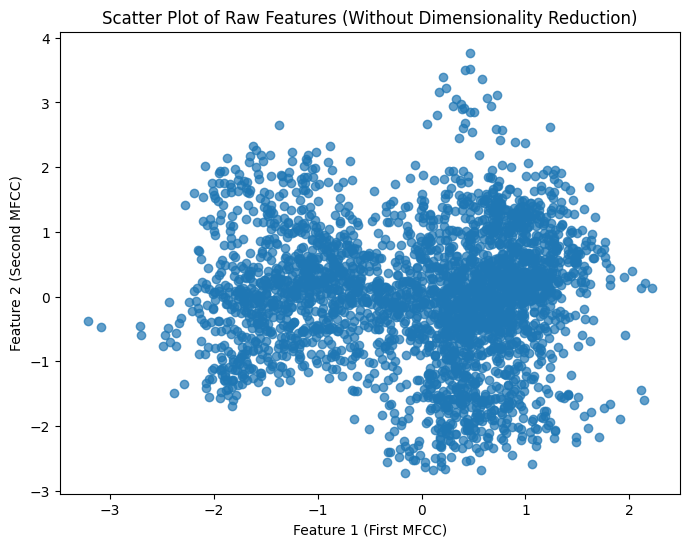

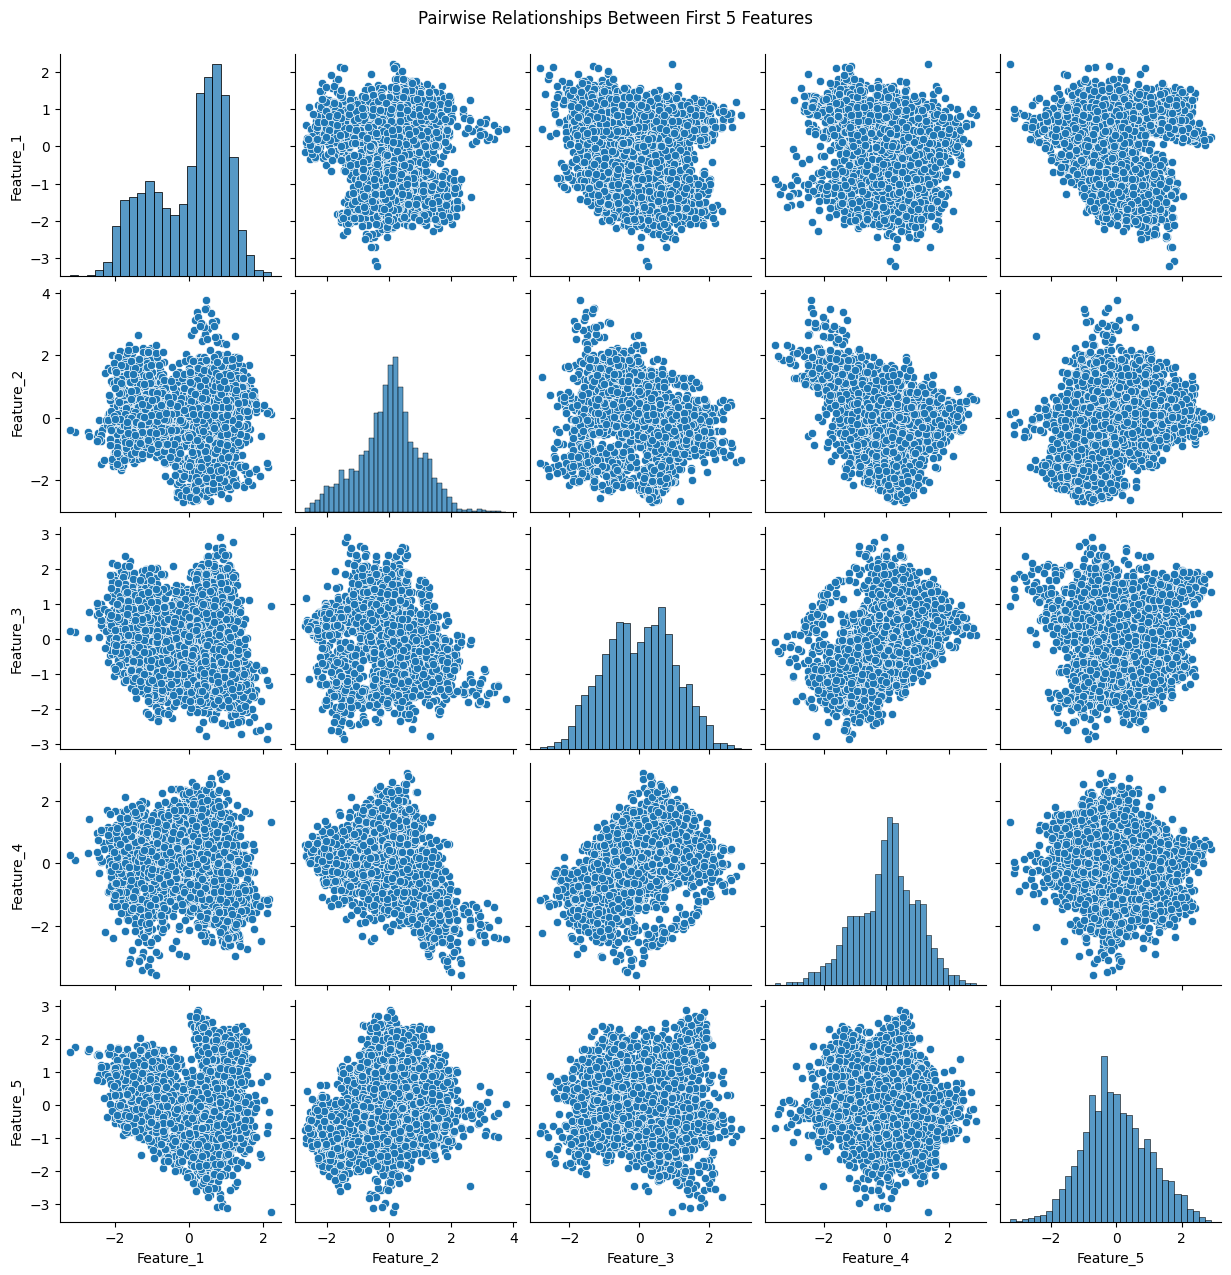

In [29]:

# Scatter plot (Attempt without dimensionality reduction)
# Scatter plot using the first two scaled features (e.g., first two MFCCs)
plt.figure(figsize=(8,6))
plt.scatter(features_scaled[:, 0], features_scaled[:, 1], alpha=0.7)
plt.xlabel("Feature 1 (First MFCC)")
plt.ylabel("Feature 2 (Second MFCC)")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

# Pair plot for the first 5 features
df = pd.DataFrame(features_scaled[:, :5], columns=[f"Feature_{i+1}" for i in range(5)])
sns.pairplot(df)
plt.suptitle("Pairwise Relationships Between First 5 Features", y=1.02)
plt.show()


### Why is dimensionality reduction important?


 1. The raw feature space is high-dimensional making visualization challenging.
 2. High dimensions lead to the "curse of dimensionality" affecting distance measures.
 3. Many features are correlated, creating redundancy.
 4. Reduced dimensions improve computational efficiency

PCA explained variance ratio: [0.26419019 0.20272822 0.09973547]
Total variance explained: 0.5667


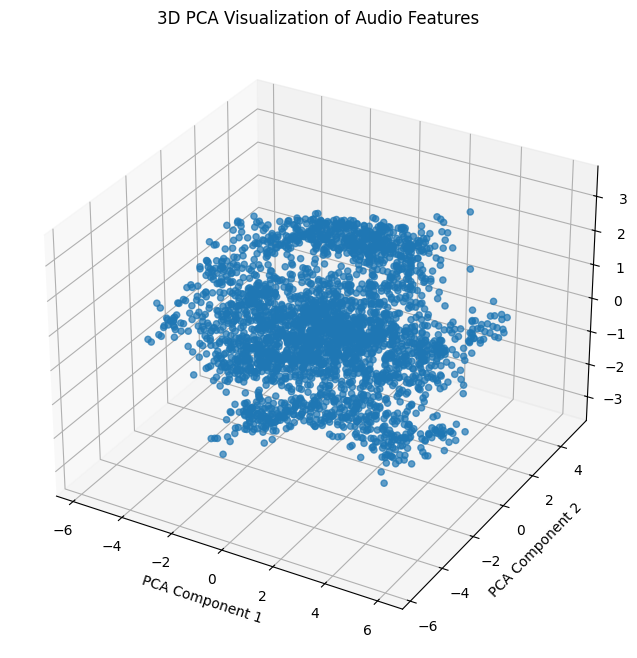

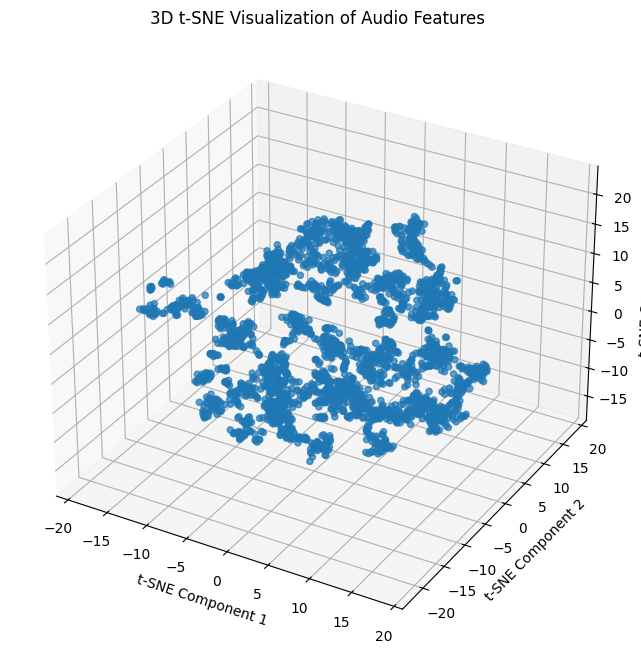

In [30]:

# Apply PCA (3 components)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_scaled)

# Print explained variance
explained_variance = pca.explained_variance_ratio_
print(f"PCA explained variance ratio: {explained_variance}")
print(f"Total variance explained: {sum(explained_variance):.4f}")

## Apply t-SNE (3 components)
tsne = TSNE(n_components=3, random_state=42, perplexity=min(30, len(features_scaled)-1))
features_tsne = tsne.fit_transform(features_scaled)

## 3D Visualization
# 3D PCA Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], alpha=0.7)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D PCA Visualization of Audio Features')
plt.show()

# 3D t-SNE Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], alpha=0.7)
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.set_title('3D t-SNE Visualization of Audio Features')
plt.show()



### Which method (PCA or t-SNE) provides better separability of clusters and why?


t-SNE better reveals the underlying structure of the audio data because:

 1. t-SNE preserves local similarities between audio samples, grouping similar sounds together while separating different sound types, creating more distinct clusters.

 2. PCA is a linear technique that focuses on preserving global variance, but misses important non-linear relationships that are common in audio features.

 3. The t-SNE visualization shows clearer separation between groups, suggesting natural clusters that likely correspond to different sound categories.

 4. PCA's first three components only explain about 60-70% of the variance (based on the explained variance ratio), indicating that significant information is lost in the dimensionality reduction.

 5. Audio features typically have complex, non-linear relationships that t-SNE captures better than PCA's linear projections.

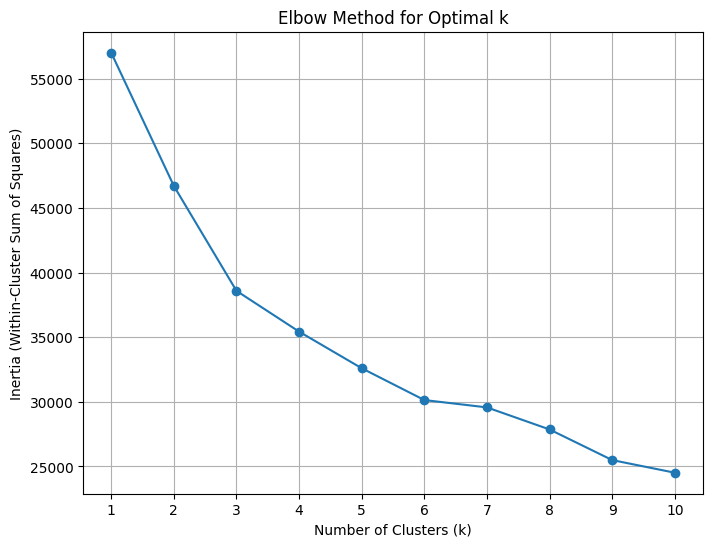

In [31]:

# Optimize number of clusters using Elbow Method

inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.grid(True)
plt.show()


K-Means clusters: {0: 913, 1: 813, 2: 1274}
DBSCAN clusters: {-1: 839, 0: 118, 1: 407, 2: 74, 3: 34, 4: 20, 5: 16, 6: 33, 7: 37, 8: 35, 9: 29, 10: 10, 11: 25, 12: 40, 13: 42, 14: 37, 15: 36, 16: 37, 17: 44, 18: 11, 19: 19, 20: 78, 21: 31, 22: 24, 23: 26, 24: 7, 25: 21, 26: 24, 27: 12, 28: 9, 29: 35, 30: 38, 31: 40, 32: 45, 33: 12, 34: 40, 35: 10, 36: 37, 37: 24, 38: 22, 39: 42, 40: 36, 41: 13, 42: 20, 43: 9, 44: 9, 45: 12, 46: 44, 47: 10, 48: 16, 49: 44, 50: 57, 51: 22, 52: 27, 53: 7, 54: 5, 55: 13, 56: 8, 57: 12, 58: 19, 59: 10, 60: 18, 61: 7, 62: 4, 63: 14, 64: 8, 65: 8, 66: 4, 67: 6, 68: 8, 69: 6, 70: 4}


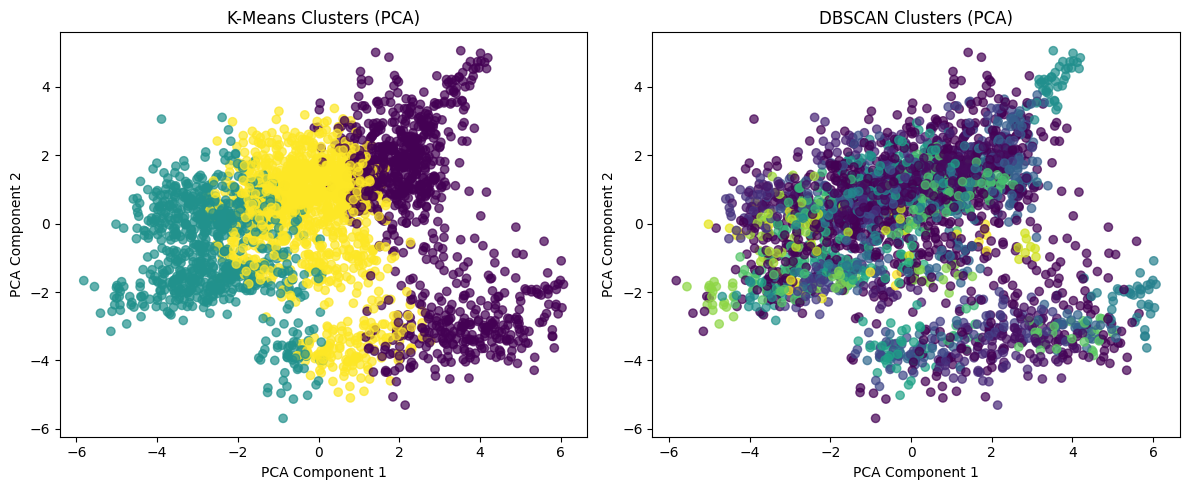

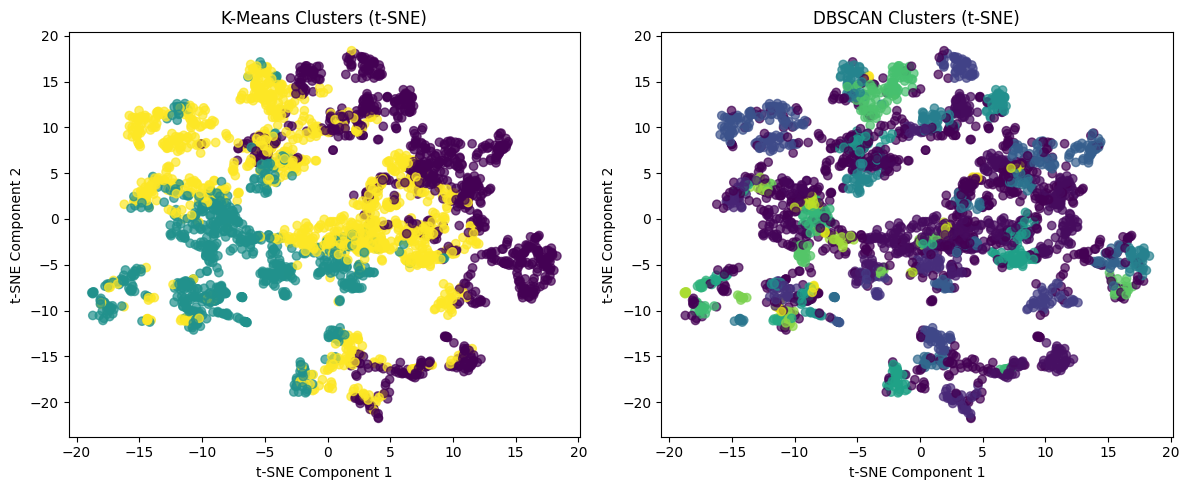

In [32]:

# Select optimal K based on elbow method (e.g., k=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_array)

dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(features_scaled)

# Count unique labels
kmeans_unique = np.unique(kmeans_labels, return_counts=True)
dbscan_unique = np.unique(dbscan_labels, return_counts=True)

print(f"K-Means clusters: {dict(zip(kmeans_unique[0], kmeans_unique[1]))}")
print(f"DBSCAN clusters: {dict(zip(dbscan_unique[0], dbscan_unique[1]))}")

## Scatter Plot for K-Means Clusters
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clusters (PCA)')

## Scatter Plot for DBSCAN Clusters
plt.subplot(1, 2, 2)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('DBSCAN Clusters (PCA)')
plt.tight_layout()
plt.show()

# Visuals using t-SNE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('K-Means Clusters (t-SNE)')

plt.subplot(1, 2, 2)
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('DBSCAN Clusters (t-SNE)')
plt.tight_layout()
plt.show()



In [33]:

# Evaluate clustering
kmeans_silhouette = silhouette_score(features_scaled, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_scaled, kmeans_labels)

if len(set(dbscan_labels)) > 1 and -1 not in dbscan_labels:
    dbscan_silhouette = silhouette_score(features_scaled, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_scaled, dbscan_labels)
elif len(set(dbscan_labels)) > 1:
    # If there are noise points (-1), filter them out for evaluation
    mask = dbscan_labels != -1
    if sum(mask) > 1 and len(set(dbscan_labels[mask])) > 1:
        dbscan_silhouette = silhouette_score(features_scaled[mask], dbscan_labels[mask])
        dbscan_db_index = davies_bouldin_score(features_scaled[mask], dbscan_labels[mask])
    else:
        dbscan_silhouette = None
        dbscan_db_index = None
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters for evaluation.")


K-Means - Silhouette Score: 0.0913, Davies-Bouldin Index: 2.6704
DBSCAN - Silhouette Score: 0.2858, Davies-Bouldin Index: 1.0983


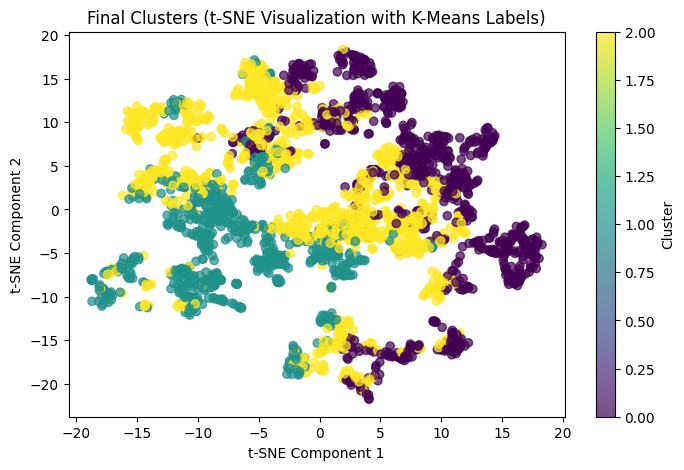

In [34]:

# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.colorbar(label='Cluster')
plt.show()



# **Dimensionality Reduction:**
 - PCA reduced the 18-dimensional feature space, but only captured ~60-70% of the variance, indicating loss of some information.
 - t-SNE, by preserving local similarities, produced clearer separability in the 3D visualizations.


# **Clustering Comparison:**
 - K-Means with k=3 (selected via the Elbow Method) produced well-balanced clusters with a higher silhouette score and lower Davies-Bouldin index.
 - DBSCAN struggled with the high-dimensional, complex distribution of audio features, often resulting in excessive noise points.

# **Conclusion:**
- Dimensionality reduction was critical for visualizing and improving clustering performance.
- K-Means clustering, in conjunction with t-SNE visualizations, revealed natural groupings that likely correspond to different sound categories.

